# 初めての列生成法

オペレーションズ・リサーチ学会の学会誌に掲載された「初めての列生成法」(宮本　裕一郎)を参考に、列生成法を実装してみる。

http://www.orsj.or.jp/archive2/or57-04/or57_4_198.pdf



## 1. ビンパッキング問題

> さまざまな大きさのアイテムと均一な大きさのビンが与えられているとする．このとき，使うビンの個数をなるべく少なくするような，アイテムのビンへの詰め込み（割り当て）を決める問題をビンパッキング問題という．
> 
> ビンパッキング問題を数理的に，ある程度厳密に，定義するため，以下に入力・出力・制約・目的を記す．
> 
> - 入力: ビンの容量 $B$，ビンに詰めるべきアイテムの集合 $I := {1,...,n}$，各アイテム $i ∈ I$ の大きさ $s_i$
> 
> - 出力: 使うビンの数を最小にするような，ビンへのアイテムの詰め込み（割り当て）
> 
> - 制約: 各ビンに詰め込まれるアイテムの大きさの合計はビンの容量以下
> 
> - 目的:（アイテムを詰めるために）使うビンの数最小化

## 2. 素直な整数線形計画問題として定式化

変数:

$\qquad\qquad\quad\;\; x_{ij}\in\{0,1\}$: アイテムiをビンjの詰め込むかどうか

$\qquad\qquad\quad\;\; y_{j}\in\{0,1\}$: ビンjにアイテムが入っているかどうか

$ minimize\qquad\; \Sigma_{j\in J}{y_j}$

$ subject \; to \qquad \Sigma_{j\in J}{x_{ij} = 1} \quad (i \in I)$  ※アイテム$i$を1回詰め込む

$ \qquad\qquad\quad\;\; \Sigma_{i\in I}{s_{i}x_{ij} = \le By_j} \quad (j \in J)$  ※ビン$j$に入っているアイテムのサイズ合計が、容量$B$を超えない

### 整数線形計画ソルバー(CBC)で実装

アイテム数$N$, ビンの容量$B$, アイテムのサイズ$s_i\in\{1,2,...,S\}$とし、ランダムな問題を生成してみる

In [1]:
from mip import Model, maximize, minimize, xsum
import mip
import random
import time

In [2]:
model = Model()
for i in range(5):
    for j in range(3):
        model.add_var("x_"+str(i)+"_"+str(j), lb=0, ub=1, var_type=mip.BINARY) 
model.vars[0].name

'x_0_0'

In [14]:
class BinPacking:
    def __init__(self, N, B, S):
        self.model = Model()
        self.N = N
        self.B = B
        self.S = S
        self.s = [random.randint(1, S) for i in range(N)]
    
    def AddVariable(self):
        self.x = {
            (i,j):
            self.model.add_var(name="x_"+str(i)+"_"+str(j), lb=0, ub=1, var_type=mip.BINARY) 
            for i in range(self.N) for j in range(self.N)
        }
        self.y ={
            j: self.model.add_var(name="y_"+str(j), lb=0, ub=1, var_type=mip.BINARY) for j in range(self.N)
        }
    def AddConstraint(self):
        for i in range(self.N):
            self.model += (
                xsum(
                    self.x[i, j] for j in range(self.N)
                ) == 1
            )
        for j in range(self.N):
            self.model += (
                xsum(
                    self.s[i] * self.x[i, j] for i in range(self.N)
                ) <= self.B * self.y[j]
            )
    def AddObjective(self):
        self.model += xsum(self.y[j] for j in range(self.N))
    def Solve(self, timeLimit = 100):
        self.status = self.model.optimize(max_seconds=timeLimit)
        return self.status

### 小規模な問題を解いてみる

アイテム数$N=10$, ビンの容量$B=10$, アイテムのサイズ$s_i\in\{1,2,...,10\}$

In [19]:
bpp = BinPacking(10, 10, 10)
bpp.AddVariable()
bpp.AddConstraint()
bpp.AddObjective()
status = bpp.Solve(100)
print("Optimal: ", status == mip.OptimizationStatus.OPTIMAL)
print("Objective: ", bpp.model.objective_value)

Optimal:  True
Objective:  6.0


結果の標準出力: 

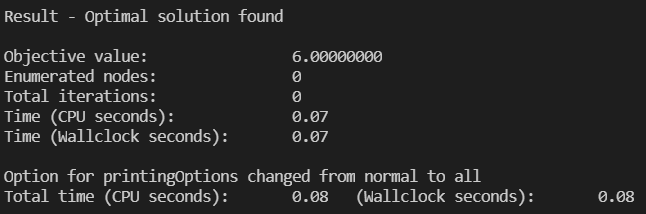

一瞬で解ける

### アイテム数を増やしていくと

In [27]:
n_items = range(10, 30, 2)
elapsed_times = []
for N in n_items:
    bpp = BinPacking(N, 10, 10)
    bpp.AddVariable()
    bpp.AddConstraint()
    bpp.AddObjective()
    t0 = time.time()
    bpp.Solve(10)
    t1 = time.time()
    elapsed_times.append(t1 - t0)
    print("Optimal: ", status == mip.OptimizationStatus.OPTIMAL)
    print("Time: ", t1 - t0)

Optimal:  True
Time:  0.24117588996887207
Optimal:  True
Time:  0.09923362731933594
Optimal:  True
Time:  0.14638233184814453
Optimal:  True
Time:  0.8983285427093506
Optimal:  True
Time:  0.35636162757873535
Optimal:  True
Time:  0.5000162124633789
Optimal:  True
Time:  10.112789630889893
Optimal:  True
Time:  0.6471285820007324
Optimal:  True
Time:  0.38181042671203613
Optimal:  True
Time:  10.066980361938477


Optimalと言っているが、これはpython-mipのバグで、最適解ではないことがある。

Text(0, 0.5, 'seconds to optimal')

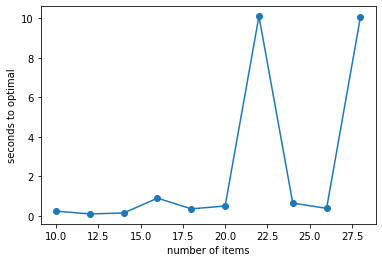

In [28]:
import matplotlib.pyplot as plt
plt.plot(n_items, elapsed_times, "o-")
plt.xlabel("number of items")
plt.ylabel("seconds to optimal")

アイテム数Nが大きくなると、変数の数が$N^2 + N$と増えていき、求解にかかる時間は長くなる。

乱数によるばらつきがあるが、問題の質によってはいつまでたっても解けないケースも出てくる。

今回は10秒で計算を終了しているが、実際には1h以上かかることもある。

## 3. パターン列挙による定式化

次に、変数の数がアイテム数の指数関数になるような定式化を行う。

アイテム$i \in I$の詰め合わせパターン$j \in J$を列挙し、$j$に$i$が含まれているか否かを行列$A = \{ a_{ij} \}$で表すと、

変数:$\qquad\qquad x_{j}\in\{0,1\}$: 1つのビンへの詰め合わせパターン$j\in J$を採用するかどうか

$ minimize\qquad\; \Sigma_{j\in J}{x_j}$

$ subject \; to \qquad \Sigma_{j\in J}{a_{ij}x_{j} \ge 1} \quad (i \in I)$  ※アイテム$i$を1回以上詰め込む

※制約条件が「1回以上」となっているが、本当は「1回だけ」でも良い。得られた解に対して、後処理で重複したアイテムを削除すればいいので、1回以上でも解ける。

この定式化で厳密解を求めるには、$2^N$パターンの詰め合わせを列挙して、変数としなければならない。これをそのまま解くのは大変である。

## 4. 列生成法

このようにパターン列挙による定式化を行い、列生成法で解くことで、高速に厳密解を得られる場合がある。

列生成法は、列挙する詰め込みパターン$j$を少しずつ増やしていきながら部分問題を解き、最適解を得られるまで変数を拡張していくような方法である。

具体的な手順は以下の通りである。

1. 少なくとも実行可能解が得られる程度の詰め込みパターンを列挙し、暫定的な整数線形計画問題を作る。

2. 整数線形計画問題を線形緩和し、その双対問題定義する。主問題の変数の数n, 制約条件の数をmとすると、双対問題の変数の数はm, 制約条件の数はnとなる。

3. 双対問題を解く。

4. 3で得られた最適解が満たせない制約条件を発見する。そのような制約がなければ終了。

5. 4で得られた制約条件を双対問題に追加する。また、その制約条件に対応する詰め込みパターンを主問題の変数として追加する。。

6. 終了条件を満たすまで3~5を繰り返す

7. これまでに追加された詰め込みパターンを用いて、主問題を整数線形計画問題として解く

ここで重要なのは、3をどうやって行うかである。制約条件を1つずつ探しているのでは、結局全パターンを列挙するのと同じことになってしまう。

ビンパッキング問題においては、これを効率的に計算することができるので、実装してみる。

### 4-1. 実行可能解を得られる最低限の詰め込みパターンを列挙

手っ取り早くまあまあの解が得られるのは貪欲法だが、今回はあえて近似解法に頼らないで、最弱の解からスタートしよう。

ビンパッキングにおいて最弱の解は、1つのビンに1つのアイテムだけをつめこんでいくパターンである。つまり、アイテム数が$N$の場合使用するビンの詰め合わせ数も$N$になる。この$N$パターンの詰め合わせを列挙しよう。

$N$個のパターン$j \in \{ 1...N\}$に異なるアイテム$i \in \{ 1...N \}$の1枚に1が立ち、残りが0になるように、初期の$A = {a_{ij}}$を単位行列で定義する。

In [29]:
import numpy as np

In [30]:
bpp = BinPacking(100, 10, 10)
A = np.eye(bpp.N)
A

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

### 4-2, 4-3. 線形緩和し、その双対問題を解く
列生成法が使えるためには、線形緩和問題の解が元の整数線形計画問題の解と等しくなる、解の整数性の性質が必要となる。

今回の定式化においてこの性質が満たされることは、小規模な問題をLPとMIPで解いてみて、結果を比較することで確認できる。

ただしこのやり方で数学的に証明できるわけではないので、注意が必要である。多分制約条件式が一定の条件(完全単模性？)を満たす場合に、整数解が得られることを証明できるが、今回は省略する。

線形緩和問題は以下のようになる。

$ minimize\qquad\; \Sigma_{j\in J_k}{x_j}$

$ subject \; to \qquad \Sigma_{j\in J_k}{a_{ij}x_{j} \ge 1} \quad (i \in I)$ 

$ \qquad\qquad\quad\;\; 0 \le x_{j}\quad$ 　※$x_j \le 1$の制約条件は、省略可能

これを主問題としたときの双対問題は、以下のようになる。

$ maximize\qquad\; \Sigma_{i\in I}{y_i}$

$ subject \; to \qquad \Sigma_{i\in I}{a_{ij}y_{i} \le 1} \quad (j \in J_k)$ 

$ \qquad\qquad\quad\;\; 0 \le y_{i}$

$J_k$は、k回目のイテレーション時のアイテムの詰め込みパターンである。毎回詰め込みパターンを１つずつ追加していくので、$J_k$の要素数は1ずつ増加していく。

主問題の変数が、双対問題では制約条件に対応している。つまり、双対問題では現状考慮されている詰め込みパターン$J_k$の個数だけ制約条件がある。

本来は全ての詰め込みパターンを変数(主問題における)に入れなければ最適解は得られないが、今回は一部しか入れていないので、双対問題においては制約条件が少なく、実際の最適解よりも良い答え(最大化問題なので、大きい最適値)が得られる。

In [41]:
num_patterns = A.shape[1]
model = Model()
y = {i: model.add_var(name="y_"+str(i), lb=0, var_type=mip.CONTINUOUS) for i in range(bpp.N)}
for j in range(num_patterns):
    model += xsum(
        A[i, j] * y[i] for i in range(bpp.N)
    ) <= 1
model.objective = mip.maximize(xsum(y[i] for i in range(bpp.N)))

緩和問題を解く。

In [43]:
status = model.optimize()
print("Optimal: ", status == mip.OptimizationStatus.OPTIMAL)
print("Objective: ", model.objective_value)
for i in range(bpp.N):
    if y[i].x > 0:
        print("y["+str(i)+"]: ", y[i].x)

Optimal:  True
Objective:  100.0
y[0]:  1.0
y[1]:  1.0
y[2]:  1.0
y[3]:  1.0
y[4]:  1.0
y[5]:  1.0
y[6]:  1.0
y[7]:  1.0
y[8]:  1.0
y[9]:  1.0
y[10]:  1.0
y[11]:  1.0
y[12]:  1.0
y[13]:  1.0
y[14]:  1.0
y[15]:  1.0
y[16]:  1.0
y[17]:  1.0
y[18]:  1.0
y[19]:  1.0
y[20]:  1.0
y[21]:  1.0
y[22]:  1.0
y[23]:  1.0
y[24]:  1.0
y[25]:  1.0
y[26]:  1.0
y[27]:  1.0
y[28]:  1.0
y[29]:  1.0
y[30]:  1.0
y[31]:  1.0
y[32]:  1.0
y[33]:  1.0
y[34]:  1.0
y[35]:  1.0
y[36]:  1.0
y[37]:  1.0
y[38]:  1.0
y[39]:  1.0
y[40]:  1.0
y[41]:  1.0
y[42]:  1.0
y[43]:  1.0
y[44]:  1.0
y[45]:  1.0
y[46]:  1.0
y[47]:  1.0
y[48]:  1.0
y[49]:  1.0
y[50]:  1.0
y[51]:  1.0
y[52]:  1.0
y[53]:  1.0
y[54]:  1.0
y[55]:  1.0
y[56]:  1.0
y[57]:  1.0
y[58]:  1.0
y[59]:  1.0
y[60]:  1.0
y[61]:  1.0
y[62]:  1.0
y[63]:  1.0
y[64]:  1.0
y[65]:  1.0
y[66]:  1.0
y[67]:  1.0
y[68]:  1.0
y[69]:  1.0
y[70]:  1.0
y[71]:  1.0
y[72]:  1.0
y[73]:  1.0
y[74]:  1.0
y[75]:  1.0
y[76]:  1.0
y[77]:  1.0
y[78]:  1.0
y[79]:  1.0
y[80]:  1.0
y[81]

### 4-4. 暫定の最適解が満たせない制約条件を発見する

結論だけ述べると、以下のようなナップサック問題を解くことで、現状の解が満たせていない、最も厳しい制約条件を発見できる。目的関数の最適値が1より大きい場合、満たせない制約条件が存在する。

変数:$\qquad\qquad \alpha_{i}\in\{0,1\}$

$ maximize\qquad\; \Sigma_{i\in I}{y_i\alpha_i}$

$ subject \; to \qquad \Sigma_{i\in I}{s_{i}\alpha_{i} \le B} $ 


なぜこの問題を解くことが、満たせない制約条件の発見につながるのかは、Appendixで説明する。

では、実際に解いてみよう

In [44]:
ks_problem = Model()

y_const = [y[i].x for i in range(bpp.N)]

alpha = {i: ks_problem.add_var(name="alpha_" + str(i), lb=0, ub=1, var_type=mip.BINARY) for i in range(bpp.N)}

ks_problem += xsum(alpha[i]*bpp.s[i] for i in range(bpp.N)) <= bpp.B

ks_problem.objective = mip.maximize(xsum(alpha[i] for i in range(bpp.N)))


In [45]:
ks_problem.optimize()

<OptimizationStatus.OPTIMAL: 0>

In [46]:
ks_problem.objective_value

8.0

### 4-5. 制約条件を追加する

4-4で求めた最適解を見てみよう。1が立っているところだけprintする。

In [48]:
for i in range(bpp.N):
    if alpha[i].x > 0:
        print("alpha["+str(i)+"]: ", alpha[i].x, "  size["+str(i)+"]: ", bpp.s[i])

alpha[19]:  1.0   size[19]:  2
alpha[27]:  1.0   size[27]:  1
alpha[56]:  1.0   size[56]:  1
alpha[57]:  1.0   size[57]:  1
alpha[62]:  1.0   size[62]:  1
alpha[73]:  1.0   size[73]:  2
alpha[81]:  1.0   size[81]:  1
alpha[97]:  1.0   size[97]:  1


この$\alpha_i$を制約条件の係数として双対問題に追加すれば、最適解が変化する。

また、この$\alpha_i$は主問題においては、列挙として追加する詰め合わせパターンである。これを繰り返して、良い詰め合わせパターンを追加していくことにより、徐々に詰め合わせが効率化されていく。

ちなみに、今回追加された詰め合わせを見てみると、ほとんどがアイテムサイズ1か2の小さなもので構成されているはずだ。

元々は全てのアイテムがバラバラのビンに入っているので、この詰め合わせを採用することでたくさんのアイテムを1つのビンに集約でき、使用するビンの数が一気に少なくなることが想像できるだろう。

双対問題において一番厳しい制約を追加することが、効率よく目的関数値を改善することにつながっていることがわかる。

ただし、ここで追加された詰め合わせは、長期的には使われなくなることが容易に想像できる。なぜなら、小さいアイテムばかり組み合わせてビンに詰め込んでしまうと、大きなアイテムが余って単独で詰め込まれ、効率が落ちてしまうからである。したがって、毎回追加される制約条件(=主問題での詰め合わせ)は、現状を鑑みた最適であるものの、最終的に必要になるとは限らないことを認識しておこう。

## 5. 列生成法の実装

反復して、主問題の解を求めるところまで実装してみよう

False

In [79]:
class BinPackingColGen:
    def __init__(self, N, B, S, timeLimit=100):
        self.problem = Model()
        self.N = N
        self.B = B
        self.S = S
        self.s = [random.randint(1, S) for i in range(N)]
        self.max_seconds = timeLimit
        self.STATUS_SOLVED = 1
        self.STATUS_SOLVING = 0
        self.STATUS_TIMEOUT = 2
        self.solve_status = self.STATUS_SOLVING
        # 最弱の詰め合わせパターン
        self.A = np.eye(self.N)
    def SolvePrimalProblem(self):
        """最低限の詰め込みパターンを列挙して、主問題を定義する
        """
        self.p_problem = Model()
        # 変数
        self.x = {
            j: self.p_problem.add_var(name="x_"+str(j), lb=0, ub=1, var_type=mip.BINARY) for j in range(self.A.shape[1])
        }
        # 制約条件
        for i in range(self.N):
            self.p_problem += xsum(self.A[i, j] * self.x[j] for j in range(self.A.shape[1])) >= 1
        # 目的関数
        self.p_problem += xsum(self.x[j] for j in range(self.A.shape[1]))
        self.p_problem.verbose = 0
        self.p_problem.optimize(max_seconds = self.max_seconds)
        
    def InitDualProblem(self):
        """線形緩和した双対問題を定義する
        """
        self.d_problem = Model()
        # 変数
        self.y = {
            i: self.d_problem.add_var("y_"+str(i), lb=0, ub=1, var_type=mip.CONTINUOUS) for i in range(self.N)
        }
        # 制約条件
        for j in range(self.A.shape[1]):
            self.d_problem += (
                xsum(
                    self.A[i, j]*self.y[i] for i in range(self.N)
                ) <= 1
            )
        self.d_problem.objective = mip.maximize(xsum(
            self.y[i] for i in range(self.N)
        ))
        
    def SolveKnapsackProblem(self):
        """双対問題の解を用いて、ナップサック問題を定義する
        """
        self.k_problem = Model()
        self.y_const = [self.y[i].x for i in range(self.N)]
        #print(self.y_const)
        self.alpha = {i: self.k_problem.add_var(name="alpha_" + str(i), lb=0, ub=1, var_type=mip.BINARY) for i in range(self.N)}
        self.k_problem += xsum(self.alpha[i]*self.s[i] for i in range(self.N)) <= self.B
        self.k_problem.objective = mip.maximize(xsum(self.alpha[i]*self.y_const[i] for i in range(self.N)))
        self.k_problem.verbose=0
        result = self.k_problem.optimize(max_seconds=self.max_seconds)
        return result
        
    def SolveDualLP(self):
        self.d_problem.verbose=0
        self.d_problem.optimize(max_seconds=self.max_seconds)
    def ColumnGeneration(self):
        """列生成法で解く
        """
        # 2. 双対問題の初期化
        self.InitDualProblem()
        itr = 0
        while self.solve_status == self.STATUS_SOLVING:
            # 3. 双対問題を解く
            self.SolveDualLP()
            print(self.d_problem.objective_value)
            # 4. A双対問題の解を用いてナップサック問題を解く
            result = self.SolveKnapsackProblem()
            if result != mip.OptimizationStatus.OPTIMAL:
                self.solve_status = self.STATUS_TIMEOUT
                print("TimeOutError!")
            elif self.k_problem.objective_value <= 1:
                # 最適値が1以下の場合、終了
                self.solve_status = self.STATUS_SOLVED
                out_str = "Epoch: " + str(itr) + "\n"
                out_str = "DP objective: " + str(self.d_problem.objective_value) + "\n"
                out_str += "KP objective: " + str(self.k_problem.objective_value)
                print(out_str)
            else:
                # 5. ナップサック問題の解から、双対問題に制約条件を追加
                new_items = np.array([self.alpha[i].x for i in range(self.N)])
                self.A = np.hstack((self.A, new_items.reshape(len(new_items), 1)))
                self.d_problem += xsum(
                    self.A[i, -1] * self.y[i] for i in range(self.N)
                ) <= 1
                #self.InitDualProblem()
                # 追加したアイテム詰め合わせを表示
                #print(new_items)
                out_str = "Epoch: " + str(itr) + "\n"
                out_str = "DP objective: " + str(self.d_problem.objective_value) + "\n"
                out_str += "KP objective: " + str(self.k_problem.objective_value) + "\n"
                out_str += "Items: [" 
                for i in range(self.N):
                    if self.alpha[i].x > 0:
                        out_str += str(self.s[i]) + ","
                out_str += "]"
                print(out_str)
                itr += 1
                
        # 6. ナップサック問題の解から、主問題に詰め込みパターンを追加
        if self.solve_status == self.STATUS_SOLVED:
            print("Column generation completed! Solving primal problem.")
            self.SolvePrimalProblem()
            print("Completed! Objective value is ", str(self.p_problem.objective_value))

In [86]:
t0 = time.time()
bpp_colgen = BinPackingColGen(100, 10, 10, timeLimit=100)
bpp_colgen.ColumnGeneration()
print("Elapsed time: ", time.time() - t0)

100.0
DP objective: 100.0
KP objective: 10.0
Items: [1,1,1,1,1,1,1,1,1,1,]
91.0
DP objective: 91.0
KP objective: 6.0
Items: [2,2,2,2,1,1,]
87.0
DP objective: 87.0
KP objective: 6.0
Items: [2,2,1,1,2,2,]
84.0
DP objective: 84.0
KP objective: 5.0
Items: [2,3,1,2,2,]
81.0
DP objective: 81.0
KP objective: 5.0
Items: [2,2,2,1,3,]
79.0
DP objective: 79.0
KP objective: 5.0
Items: [2,2,2,1,3,]
79.0
DP objective: 79.0
KP objective: 5.0
Items: [3,2,2,2,1,]
79.0
DP objective: 79.0
KP objective: 5.0
Items: [2,1,2,2,3,]
79.0
DP objective: 79.0
KP objective: 4.0
Items: [1,2,3,3,]
77.5
DP objective: 77.5
KP objective: 4.0
Items: [4,3,1,2,]
77.0
DP objective: 77.0
KP objective: 5.0
Items: [2,2,2,1,3,]
77.0
DP objective: 77.0
KP objective: 5.0
Items: [2,2,1,2,3,]
76.33333333333333
DP objective: 76.33333333333333
KP objective: 3.666666666666667
Items: [1,1,2,1,3,2,]
76.0
DP objective: 76.0
KP objective: 4.0
Items: [2,1,3,3,]
75.75
DP objective: 75.75
KP objective: 4.0
Items: [3,3,3,1,]
74.8
DP objective

DP objective: 59.381105755862464
KP objective: 1.4406339790527385
Items: [1,1,1,7,]
59.321963093764964
DP objective: 59.321963093764964
KP objective: 1.4160757995899333
Items: [1,2,7,]
59.19531456409529
DP objective: 59.19531456409529
KP objective: 1.4547727521700196
Items: [1,2,7,]
59.08615136876007
DP objective: 59.08615136876007
KP objective: 1.63365539452496
Items: [1,4,1,4,]
59.03680905872
DP objective: 59.03680905872
KP objective: 1.3734762216137686
Items: [7,2,1,]
59.014326696492624
DP objective: 59.014326696492624
KP objective: 1.4389877394897748
Items: [7,3,]
58.94389681208054
DP objective: 58.94389681208054
KP objective: 1.6635906040268453
Items: [1,1,3,5,]
58.86658476658478
DP objective: 58.86658476658478
KP objective: 1.6525798525798527
Items: [1,6,3,]
58.80110173464603
DP objective: 58.80110173464603
KP objective: 1.4442100328176277
Items: [1,3,3,3,]
58.717672209026134
DP objective: 58.717672209026134
KP objective: 1.6946318289786242
Items: [2,3,1,2,1,1,]
58.7
DP objective

55.39999999999999
DP objective: 55.39999999999999
KP objective: 1.1
Items: [1,1,1,7,]
55.400000000000006
DP objective: 55.400000000000006
KP objective: 1.1000000000000003
Items: [9,1,]
55.400000000000006
DP objective: 55.400000000000006
KP objective: 1.0999999999999999
Items: [9,1,]
55.400000000000006
DP objective: 55.400000000000006
KP objective: 1.1000000000000003
Items: [9,1,]
55.32352941176472
DP objective: 55.32352941176472
KP objective: 1.2352941176470589
Items: [2,1,7,]
55.318181818181806
DP objective: 55.318181818181806
KP objective: 1.3636363636363638
Items: [2,1,2,5,]
55.315217391304344
DP objective: 55.315217391304344
KP objective: 1.1195652173913055
Items: [1,7,2,]
55.30171184022824
DP objective: 55.30171184022824
KP objective: 1.1326676176890156
Items: [8,2,]
55.3
DP objective: 55.3
KP objective: 1.1000000000000003
Items: [9,1,]
55.3
DP objective: 55.3
KP objective: 1.1
Items: [9,1,]
55.3
DP objective: 55.3
KP objective: 1.1000000000000005
Items: [2,1,7,]
55.29999999999999

In [83]:
bpp_colgen.p_problem.optimize()
bpp_colgen.p_problem.objective_value

65.0

だいたい数秒で計算が完了する。

## 6. 結局列生成法はどんな時に使える？

- 列挙するタイプの定式化ができる
- 線形緩和解が整数性を持っている(完全な整数性ではなくてもいい？)
- 双対問題が満たさない制約条件を発見することが容易である(今回はナップサック問題で表せた)

他の適用事例として、
- [容量制約付き配送計画](https://blog.brainpad.co.jp/entry/2020/10/23/000003)
- [資材切り出し問題](https://zenn.dev/umepon/articles/ff8d2ee3b6d464e24581)
などがある。

## Appendix1. なぜナップサック問題で追加すべき制約条件を発見できるか？

双対問題の非負制約以外の制約条件は、

$ subject \; to \qquad \Sigma_{i\in I}{a_{ij}y_{i} \le 1} \quad (j \in J_k)$ 

であったが、$J_k$は現在列挙された一部の詰め込みパターンなので、双対問題は一部の制約条件だけを有効化して解いていることになる。

現在列挙されていない制約条件$l \notin J_k$の中で、現在の解が満たせていないものを探す。

「双対問題の制約条件を満たさない」という制約条件は、
$$ \Sigma_{i\in I}{a_{il}y_{i} > 1} \quad (l \notin J_k)$$
と書ける。これを満たすような$a_{il}$の値を求めれば、次に加えるべき制約条件になる。しかし、条件を違反していればどれでも良いというわけではない。元の問題の解を効率よく求めるためには、できるだけ少ない数の制約条件だけで問題を再定義したい。そのためには、制約条件の中でも、できるだけ厳しいものを選ぶべきである。

そこで、制約条件の閾値からの違反量を最大化する問題を解き、現状の解目線でできるだけ厳しい制約条件を追加しよう。

すなわち、以下のように目的関数が定義できる。

変数:$\qquad\qquad a_{il}\in\{0,1\}$

$ maximize\qquad\; \Sigma_{i\in I}{y_ia_{il}}$

一方で、$a_{il}$は、アイテム$i$が詰め込みパターン$l$に入っていれば1,そうでなければ0をとるので、各詰め込みパターンのサイズ制約を満たす。

$subject \; to \qquad \Sigma_{i\in I}{s_{i}a_{il} \le B}$

これはつまり、次に詰め込むべき制約条件に対応するアイテム$i$を選別するナップサック問題である。